# <u> Forex Predictions for Fun and Profit </u>
## Project Topic
The goal of this project is to predict if the foreign exchange rate (forex) for EURUSD will drop significantly during from its opening price during a single day. This is a supervised machine learning problem, specifically a binary classification problem. The main features used will be large stock economic indexes like the DOW Jones industrial average and the S&P500.

This project has the potential to inform the user on near-term currency exchange trends. If the price of EURUSD is predicted to go down in the next trading day, then the user can make a small profit by trading the pair near the opening price and again when the price changes. The details of this transaction will be discussed in the background section.

There are still learning objectives that can be achieved even if the predictive value of the models are low.
- Creating and testing the models helps to inform the casual day or swing trader if single features are useful as a basis for trading decisions.
- The process of gathering and processing exchange and index information can easily be extended to other currency pairs and market features.

### Background
Currency pairs are traded in open markets all over the world. The price of a pair is the relative value of the two currencies. The trading hours of the major exchanges extend from Syndey, Austriala to New York, USA meaning that forex pairs can be traded 24 hours a day during the week. - https://en.wikipedia.org/wiki/Foreign_exchange_market  

For this project, the currency pair is the Euro (EUR) and the US dollar. The pair is traded as EUR/USD, where the price is lower if the denominator currency (US dollar) increases in relative value. The change in price is described as a percentage in point (pip), which is the smallest unit that the price can change. - https://en.wikipedia.org/wiki/Percentage_in_point For the EUR/USD, a pip is 0.0001. This project is focused on predicting a small but useful change in the value of the pair as 30 pips or 0.0030. 

<b>Note on the outcome chosen:</b> 
Differences in interbank rates impact the cost of 'selling' the EURUSD pair vs 'buying' the pair, such that it is less risky to predict a drop and 'sell' the pair than it is to 'buy' the pair. For example, if the model predicts the price of EURUSD will drop by 30 pips or more, then the user would sell the pair at the initial price and buy the pair at the lower price making a profit. Holding the currency pair for more than one day will result in a financing charge. When selling the pair in the US, the 'charge' is actually a small percentage paid to your account. If you hold a buy position for more than a day, the charge is negative against your account. (You could lose $1 a day or more just by keeping a buy position on the currency pair.)





In [1]:
import yfinance as yf
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

## Data
yfinance (https://pypi.org/project/yfinance/) is used to obtain the data for this project. In a production environment, a paid account with a forex provider or polygon.io should be used. The yfinance package uses the public API for Y!Finance. The data will be in tabluar, but in separate tables that need to be combined.
- EURUSD pair information: this table will have open, high, low, and close price information for the forex pair over the time period specified and at the intervals specified.
- Each index will be downloaded for the same time period and combined before processing.

The initial Total data size will be approximately 10000 rows by 30 features.  

In [2]:
eur_1hour_5day = yf.download("EURUSD=X", interval="1H",period="5d").reset_index()
eur_1hour_5day

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2024-10-14 00:00:00,1.093016,1.093135,1.092538,1.092657,1.092657,0
1,2024-10-14 01:00:00,1.092777,1.092777,1.091941,1.092538,1.092538,0
2,2024-10-14 02:00:00,1.092419,1.092777,1.092180,1.092657,1.092657,0
3,2024-10-14 03:00:00,1.092538,1.093016,1.092180,1.092777,1.092777,0
4,2024-10-14 04:00:00,1.092777,1.093255,1.092777,1.092896,1.092896,0
...,...,...,...,...,...,...,...
109,2024-10-18 13:00:00,1.085187,1.086248,1.085069,1.086248,1.086248,0
110,2024-10-18 14:00:00,1.086248,1.086602,1.085423,1.085894,1.085894,0
111,2024-10-18 15:00:00,1.086130,1.086602,1.085894,1.086012,1.086012,0
112,2024-10-18 16:00:00,1.086130,1.086248,1.085658,1.085658,1.085658,0


The candlestick plot below shows a small example of the forex pair price for each hour over a 5 day period.

In [3]:

fig = go.Figure(data=[go.Candlestick(x=eur_1hour_5day['Datetime'],
                open=eur_1hour_5day['Open'],
                high=eur_1hour_5day['High'],
                low=eur_1hour_5day['Low'],
                close=eur_1hour_5day['Close'])])

fig.show()

In [4]:
eur_1day_1month = yf.download("EURUSD=X", interval="1D",period="1mo").reset_index()
eur_1day_1month.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-09-18,1.112310,1.114082,1.110914,1.112310,1.112310,0
1,2024-09-19,1.111482,1.118068,1.107052,1.111482,1.111482,0
2,2024-09-20,1.116196,1.118168,1.113735,1.116196,1.116196,0
3,2024-09-23,1.116084,1.116819,1.108488,1.116084,1.116084,0
4,2024-09-24,1.111173,1.116346,1.110396,1.111173,1.111173,0


In [5]:
fig = go.Figure(data=[go.Candlestick(x=eur_1day_1month['Date'],
                open=eur_1day_1month['Open'],
                high=eur_1day_1month['High'],
                low=eur_1day_1month['Low'],
                close=eur_1day_1month['Close'])])

fig.show()

## Data Acquisition and Cleaning

<b> Note: </b> There is a known issue with the data coming from yfinance for the daily period. See https://github.com/ranaroussi/yfinance/issues/1071 for a description and a workaround suggested by ValueRaider that I modified in the function below.

In [6]:
def get_daily_forex_dataframe(forex = "EURUSD=X", period = "10y"):
    df = yf.download(forex, interval="1D",period=period)
    df.reset_index(inplace=True)
    df['date'] = df['Date'].dt.date
    close = np.roll(df["Open"].to_numpy(), -1) # Cleaning step
    df["Close"] = close                        # Cleaning step
    df['outcome'] = df.apply(lambda row: row.Open - row.Low, axis=1)
    df['outcome_cat'] = df.apply(lambda row: row.outcome > 0.003, axis=1)
    return df

In [7]:
eur_1day_1month = get_daily_forex_dataframe(period="1mo")

[*********************100%***********************]  1 of 1 completed


In [8]:
eur_1day_1month.head()

,Date,Open,High,Low,Close,Adj Close,Volume,date,outcome,outcome_cat
0,2024-09-18,1.112310,1.114082,1.110914,1.111482,1.112310,0,2024-09-18,0.001396,False
1,2024-09-19,1.111482,1.118068,1.107052,1.116196,1.111482,0,2024-09-19,0.004430,True
2,2024-09-20,1.116196,1.118168,1.113735,1.116084,1.116196,0,2024-09-20,0.002461,False
3,2024-09-23,1.116084,1.116819,1.108488,1.111173,1.116084,0,2024-09-23,0.007596,True
4,2024-09-24,1.111173,1.116346,1.110396,1.119119,1.111173,0,2024-09-24,0.000777,False


We can see the corrected price with open and close values.

In [9]:
fig = go.Figure(data=[go.Candlestick(x=eur_1day_1month['Date'],
                open=eur_1day_1month['Open'],
                high=eur_1day_1month['High'],
                low=eur_1day_1month['Low'],
                close=eur_1day_1month['Close'])])

fig.show()

In [10]:
eur_1day_10year = get_daily_forex_dataframe(period="10y")

[*********************100%***********************]  1 of 1 completed


In [11]:
eur_1day_10year.head()

,Date,Open,High,Low,Close,Adj Close,Volume,date,outcome,outcome_cat
0,2014-10-20,1.274892,1.278854,1.273240,1.279525,1.274957,0,2014-10-20,0.001652,False
1,2014-10-21,1.279525,1.283928,1.271710,1.271423,1.279525,0,2014-10-21,0.007815,True
2,2014-10-22,1.271423,1.273910,1.265110,1.264542,1.271472,0,2014-10-22,0.006313,True
3,2014-10-23,1.264542,1.267580,1.261702,1.265070,1.264143,0,2014-10-23,0.002840,False
4,2014-10-24,1.265070,1.269511,1.263584,1.267684,1.265406,0,2014-10-24,0.001487,False


In [12]:
fig = go.Figure(data=[go.Candlestick(x=eur_1day_10year['Date'],
                open=eur_1day_10year['Open'],
                high=eur_1day_10year['High'],
                low=eur_1day_10year['Low'],
                close=eur_1day_10year['Close'])])

fig.show()

In [13]:
eur_clean = eur_1day_10year.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close','Volume', 'Date'])

In [14]:
eur_clean.head()

,date,outcome,outcome_cat
0,2014-10-20,0.001652,False
1,2014-10-21,0.007815,True
2,2014-10-22,0.006313,True
3,2014-10-23,0.002840,False
4,2014-10-24,0.001487,False


- eur_clean: the initial dataframe with outcome of interest
- date: the day of the outcome
- outcome: the difference between the opening price and the lowest price of the day.
- outcome_cat: boolean variable indicating if the low price was more than 0.003 below the open price.

Next I select indexes that track stocks in the US and Europe.
https://finance.yahoo.com/markets/world-indices/

Below I calculate the percent change as the (open - close) / open * 100
Then I create variables for the previous days percent change.
The dataframe will have the percent change for each of the previous 3 days.
I also create categorical variables in case that helps with the ML models.

In [15]:
def get_index_dataframe(index):
    index_symbol = index[1:]
    print(index)
    df = yf.Ticker(index).history(period="10y")
    df = df.drop(columns=['Dividends', 'Stock Splits'])
    df.reset_index(inplace=True)
    df['date'] = df['Date'].dt.date
    df['perch_day0'] = df.apply(lambda row: (row.Open - row.Close) / row.Open * 100, axis=1)
    df['perch_day1'] = df['perch_day0'].shift(periods=1)
    df['perch_day2'] = df['perch_day0'].shift(periods=2)
    df['perch_day3'] = df['perch_day0'].shift(periods=3)
    df['positivech_day1'] = df['perch_day1'] > 0
    df['positivech_day2'] = df['perch_day2'] > 0
    df['positivech_day3'] = df['perch_day3'] > 0
    df = df.drop(columns=['Date', 'perch_day0', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df = df.rename(columns={"perch_day1": "perch_day1_" + index_symbol, "perch_day2": "perch_day2_" + index_symbol, "perch_day3": "perch_day3_" + index_symbol})
    df = df.rename(columns={"positivech_day1": "positivech_day1" + index_symbol, "positivech_day2": "positivech_day2" + index_symbol, "positivech_day3": "positivech_day3" + index_symbol})
    return df

In [16]:
def get_original_index_dataframe(index):
    df = yf.Ticker(index).history(period="10y")
    df = df.drop(columns=['Dividends', 'Stock Splits'])
    df.reset_index(inplace=True)
    df['date'] = df['Date'].dt.date
    df['perch_day0'] = df.apply(lambda row: (row.Open - row.Close) / row.Open * 100, axis=1)
    return df

In [17]:
index_list = ["^IXIC", "^GSPC", "^DJI", "^STOXX50E", "^FTSE","^RUT", "^GDAXI"]

In [18]:
df_list = []
for idx in index_list:
    df_list.append(get_index_dataframe(idx).set_index('date'))

^IXIC
^GSPC
^DJI
^STOXX50E
^FTSE
^RUT
^GDAXI


In [19]:
df_indexes = pd.concat(df_list, join='inner', axis=1).reset_index()

In [20]:
df_indexes.head()

,date,perch_day1_IXIC,perch_day2_IXIC,perch_day3_IXIC,positivech_day1IXIC,positivech_day2IXIC,positivech_day3IXIC,perch_day1_GSPC,perch_day2_GSPC,perch_day3_GSPC,...,perch_day3_RUT,positivech_day1RUT,positivech_day2RUT,positivech_day3RUT,perch_day1_GDAXI,perch_day2_GDAXI,perch_day3_GDAXI,positivech_day1GDAXI,positivech_day2GDAXI,positivech_day3GDAXI
0,2014-10-20,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,...,NaN,False,False,False,NaN,NaN,NaN,False,False,False
1,2014-10-21,-1.455274,NaN,NaN,False,False,False,-0.975277,NaN,NaN,...,NaN,False,False,False,1.150890,NaN,NaN,True,False,False
2,2014-10-22,-1.383522,-1.455274,NaN,False,False,False,-1.670701,-0.975277,NaN,...,NaN,False,False,False,-2.230520,1.150890,NaN,False,True,False
3,2014-10-23,1.045572,-1.383522,-1.455274,True,False,False,0.730445,-1.670701,-0.975277,...,-1.510171,True,False,False,-0.062674,-2.230520,1.15089,False,False,True
4,2014-10-24,-0.572568,1.045572,-1.383522,False,True,False,-1.025361,0.730445,-1.670701,...,-1.179217,False,True,False,-1.958289,-0.062674,-2.23052,False,False,False


In [21]:
# I drop NA rows since the first 3 dates will not have values for days before the date starts.
df_indexes = df_indexes.dropna()

## Exploratory Data Analysis

In [22]:
daily_range = eur_1day_10year.apply(lambda row: row.Open - row.Low, axis=1)
np.round(daily_range.describe() / 0.0001, 2)

count    26050000.00
mean           36.31
std            33.28
min            -1.98
25%            13.00
50%            27.60
75%            51.28
max           410.98
dtype: float64

The daily range between the open price and the low price averages 36 pips, suggesting that the outcome of 30 pips (0.0030) is appropriate. 

In [23]:
# The outcome variable is well balanced overall.
eur_1day_10year.outcome_cat.value_counts()

outcome_cat
False    1394
True     1211
Name: count, dtype: int64

In [24]:
df_join = pd.merge(left = eur_clean, right = df_indexes, how = 'inner', left_on= 'date', right_on='date')

In [25]:
df_join['date'] = pd.to_datetime(df_join['date'])
df_join['dow'] = df_join['date'].dt.day_name()

In [26]:
df_corr = df_join.drop(columns=['date', 'outcome_cat', 'dow']).corr()

<Axes: >

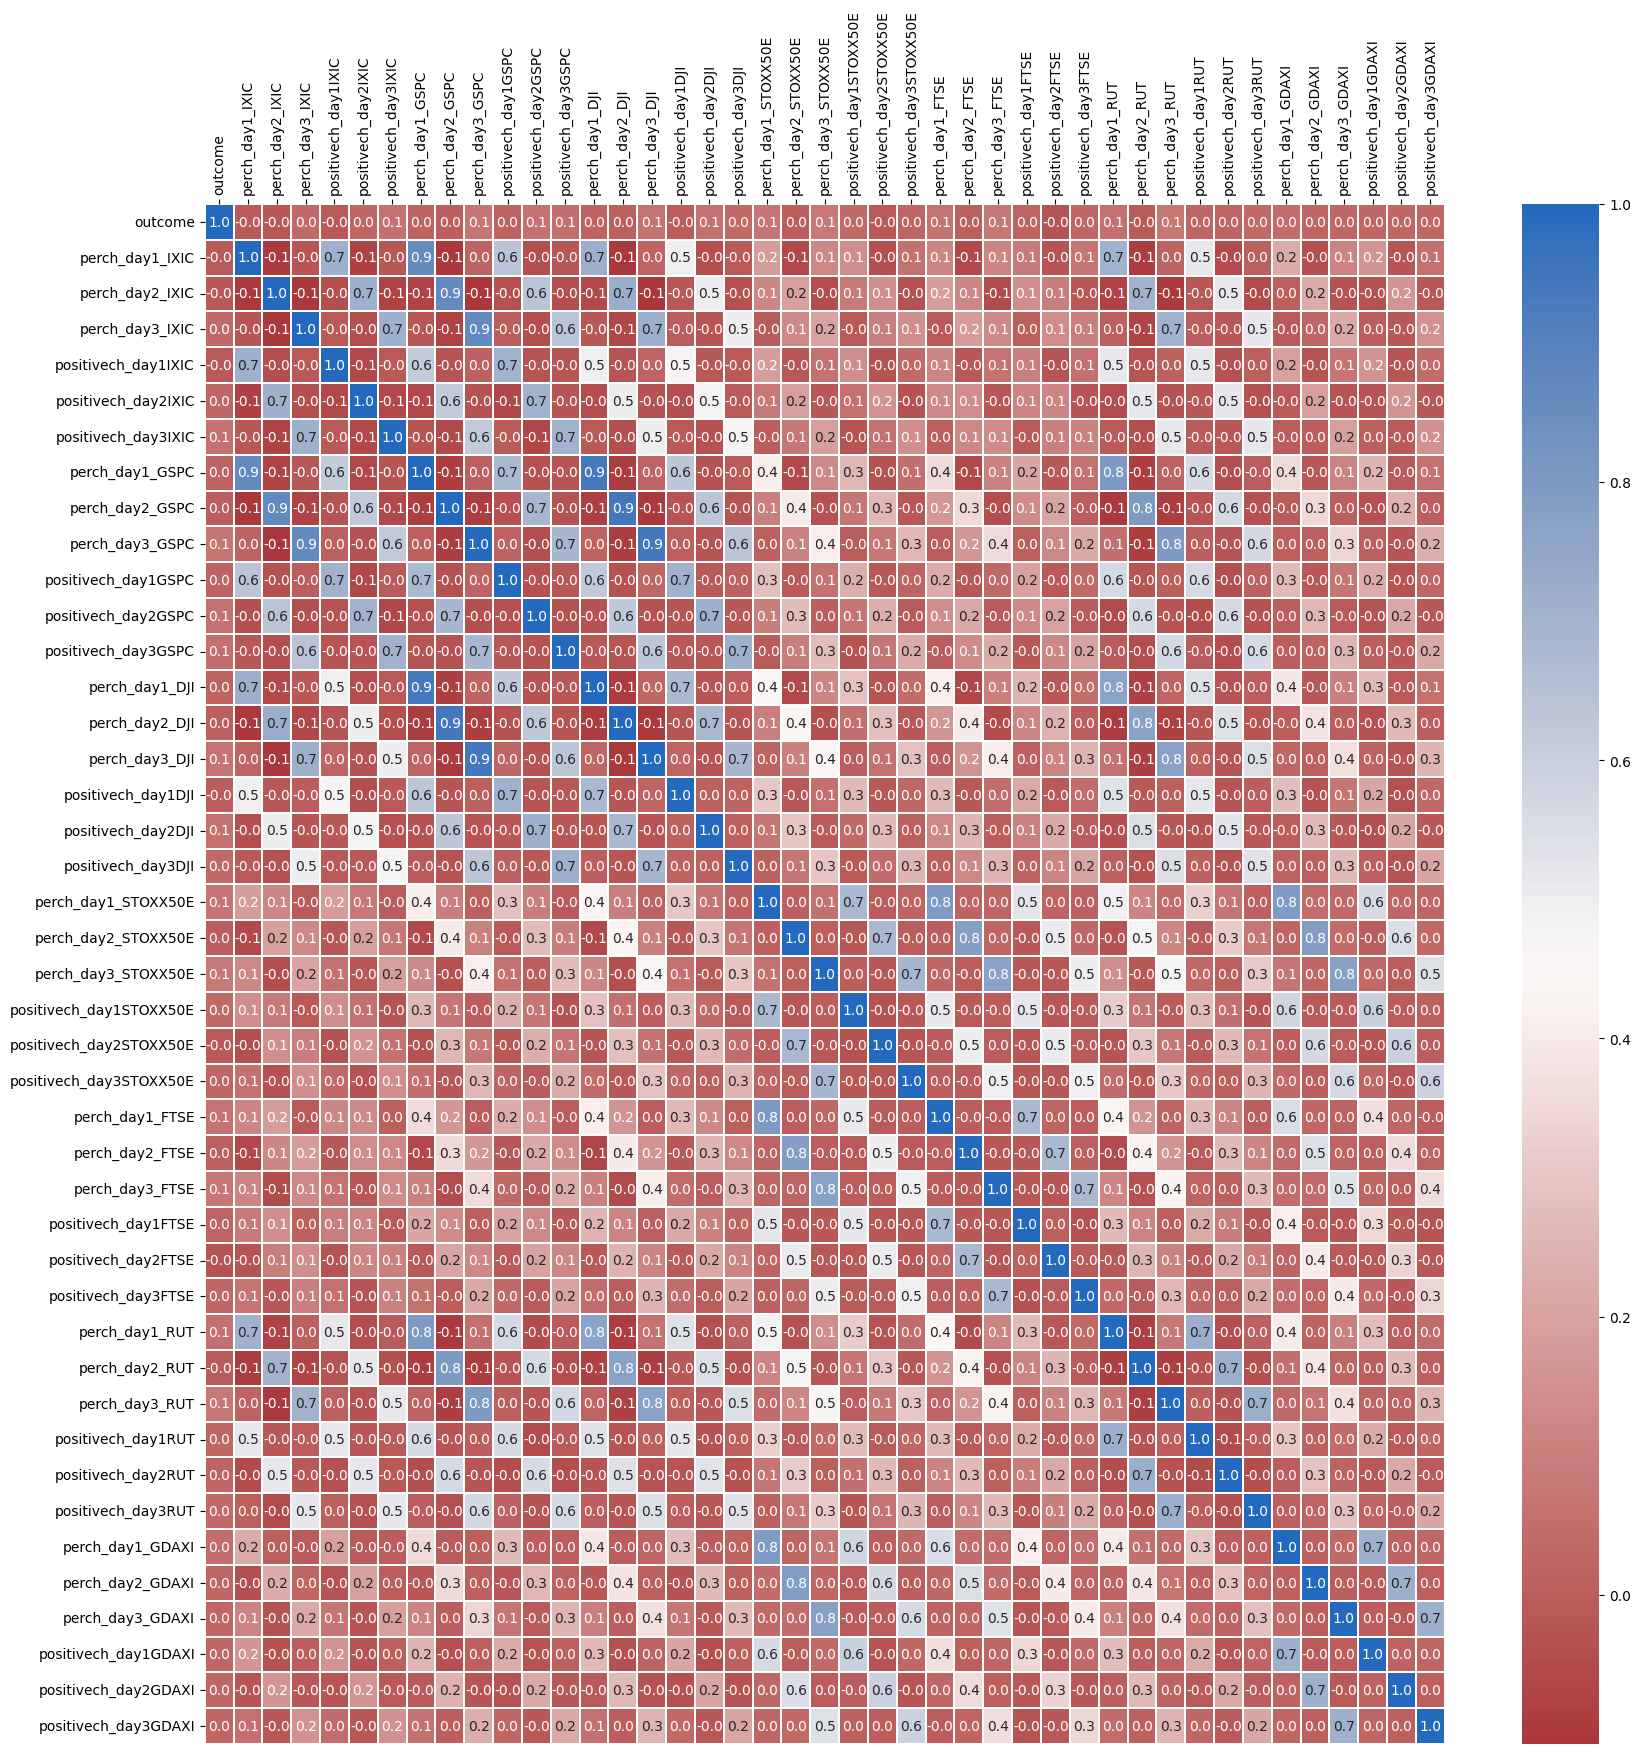

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.tick_top()
ax.tick_params(axis='x', labelrotation=90)
sns.heatmap(df_corr, linewidths=.3,  annot=True, fmt=".1f", cmap = "vlag_r")

There is very little correlation between the numeric outcome and the numeric index changes. There is a strong correlation between features, which is expected since many of different time points of the same index.

In [28]:
df_join.head()

,date,outcome,outcome_cat,perch_day1_IXIC,perch_day2_IXIC,perch_day3_IXIC,positivech_day1IXIC,positivech_day2IXIC,positivech_day3IXIC,perch_day1_GSPC,...,positivech_day1RUT,positivech_day2RUT,positivech_day3RUT,perch_day1_GDAXI,perch_day2_GDAXI,perch_day3_GDAXI,positivech_day1GDAXI,positivech_day2GDAXI,positivech_day3GDAXI,dow
0,2014-10-23,0.002840,False,1.045572,-1.383522,-1.455274,True,False,False,0.730445,...,True,False,False,-0.062674,-2.230520,1.150890,False,False,True,Thursday
1,2014-10-24,0.001487,False,-0.572568,1.045572,-1.383522,False,True,False,-1.025361,...,False,True,False,-1.958289,-0.062674,-2.230520,False,False,False,Friday
2,2014-10-27,0.000975,False,-0.544018,-0.572568,1.045572,False,False,True,-0.665611,...,False,False,True,0.230888,-1.958289,-0.062674,True,False,False,Monday
3,2014-10-28,0.001547,False,-0.378386,-0.544018,-0.572568,False,False,False,0.068262,...,False,False,False,1.962266,0.230888,-1.958289,True,True,False,Tuesday
4,2014-10-29,0.001297,False,-1.299680,-0.378386,-0.544018,False,False,False,-1.064590,...,False,False,False,-0.947682,1.962266,0.230888,False,True,True,Wednesday


In [29]:
X_with_dow = df_join.drop(columns=['date','outcome', 'outcome_cat'])
y = df_join['outcome_cat']

In [30]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes  = True)

fig.add_trace(go.Line(x = df_join['date'], y = df_join['outcome'] / 0.0001, name = "Outcome - decrease in pips"), row=1, col=1)
fig.add_trace(go.Line(x = df_join['date'], y = df_join['perch_day3_DJI'], name = 'Dow Jones index day-3'), row=2, col=1)
fig.add_trace(go.Line(x = df_join['date'], y = df_join['perch_day3_STOXX50E'], name = 'EURO STOXX 50 index day-3'), row=3, col=1)
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout( {'height':800})
fig.show()


c:\Users\hroga\Documents\CS_courses\ML1\ml1_final_project\.venv\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\hroga\Documents\CS_courses\ML1\ml1_final_project\.venv\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


c:\Users\hroga\Documents\CS_courses\ML1\ml1_final_project\.venv\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




A key check for the EDA is that our predictors, the stock indexes are matched correctly in time with the forex outcome.

## Models
Split the data into training and testing.

Start with Logistic regression to get a baseline benchmark for precision.

Next proceed to Random Forest as a way to determine feature importance since many variables are colinear (see correlation plot.)
Use precision scoring and class weight of balance to avoid training the model for just high accuracy. (We prefer to be confidently right about the predictions since there is no risk in missing a trading opportunity but it is expensive to trade at a bad time.)

End with boosting using only the important features.

Compare the 3 models using precision as primary metric and AUC for a helpful visual using the test dataset.


In [31]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix


In [32]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(X_with_dow[['dow']])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['dow']))

# Concatenate the one-hot encoded dataframe with the original dataframe
X = pd.concat([X_with_dow, one_hot_df], axis=1)

# Drop the original categorical columns
X = X.drop(['dow'], axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
y_test.value_counts()

outcome_cat
False    377
True     346
Name: count, dtype: int64

In [35]:
y_train.value_counts()

outcome_cat
False    889
True     797
Name: count, dtype: int64

### Logistic Regression

In [36]:
LogReg =  LogisticRegression(solver = "newton-cholesky").fit(X_train, y_train)

Logistic Regression training precision score:  0.5754276827371695


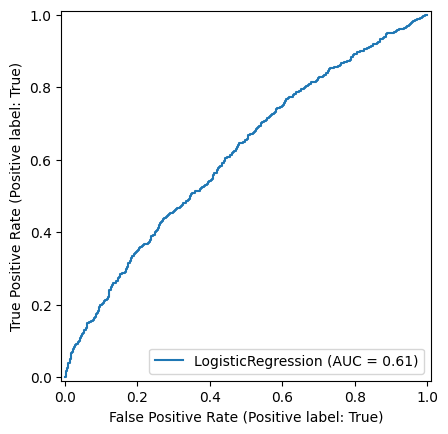

In [37]:
disp = RocCurveDisplay.from_estimator(LogReg, X_train, y_train)
log_precision_score = precision_score(y_train, LogReg.predict(X_train))
print("Logistic Regression training precision score: ", log_precision_score)

The benchmark is now set with a precision score of 0.5868. The reason for using the precision score is that we want to maximize the number of times we predict our outcome correctly vs getting it wrong.

### Random Forest


In [38]:
# Parameter ranges used from https://medium.com/@Yaga987/hyperparameter-tuning-with-random-forest-ff62882fd5bb
param_grid={
    'n_estimators': range(10, 101),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [39]:
grid_search = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced'),
                                 n_jobs = 4,
                                 cv = 5, 
                           param_distributions =param_grid,
                           scoring='precision') 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 

RandomForestClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=5,
                       min_samples_split=3, n_estimators=97)


In [40]:
model_rf = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features='log2', min_samples_leaf=5,
                       min_samples_split=10, n_estimators=14) 
model_rf.fit(X_train, y_train) 



RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features='log2', min_samples_leaf=5,
                       min_samples_split=10, n_estimators=14)

Random Forest training precision score:  0.6592920353982301


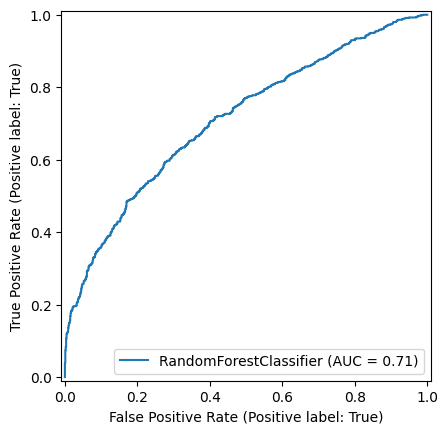

In [41]:
disp = RocCurveDisplay.from_estimator(model_rf, X_train, y_train)
rf_precision_score = precision_score(y_train, model_rf.predict(X_train))
print("Random Forest training precision score: ", rf_precision_score)

In [42]:
from sklearn.inspection import permutation_importance
feature_names = X_train.columns
result = permutation_importance(
    model_rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [43]:
forest_importances.sort_values(ascending=False)

perch_day3_STOXX50E        0.025682
dow_Friday                 0.014828
dow_Thursday               0.013820
perch_day2_STOXX50E        0.012456
perch_day2_FTSE            0.012396
perch_day1_FTSE            0.011210
perch_day3_RUT             0.009371
perch_day2_RUT             0.007414
perch_day1_GDAXI           0.006999
perch_day2_GSPC            0.006821
perch_day1_DJI             0.004923
perch_day3_DJI             0.004804
perch_day3_IXIC            0.004567
perch_day2_DJI             0.003855
perch_day3_GSPC            0.003440
perch_day3_FTSE            0.003262
dow_Wednesday              0.002966
positivech_day3RUT         0.002906
perch_day2_GDAXI           0.002728
perch_day1_STOXX50E        0.002491
perch_day1_IXIC            0.002254
perch_day2_IXIC            0.002195
perch_day3_GDAXI           0.002195
positivech_day1STOXX50E    0.001127
positivech_day3GDAXI       0.000771
positivech_day2RUT         0.000712
positivech_day3DJI         0.000000
positivech_day3STOXX50E    0

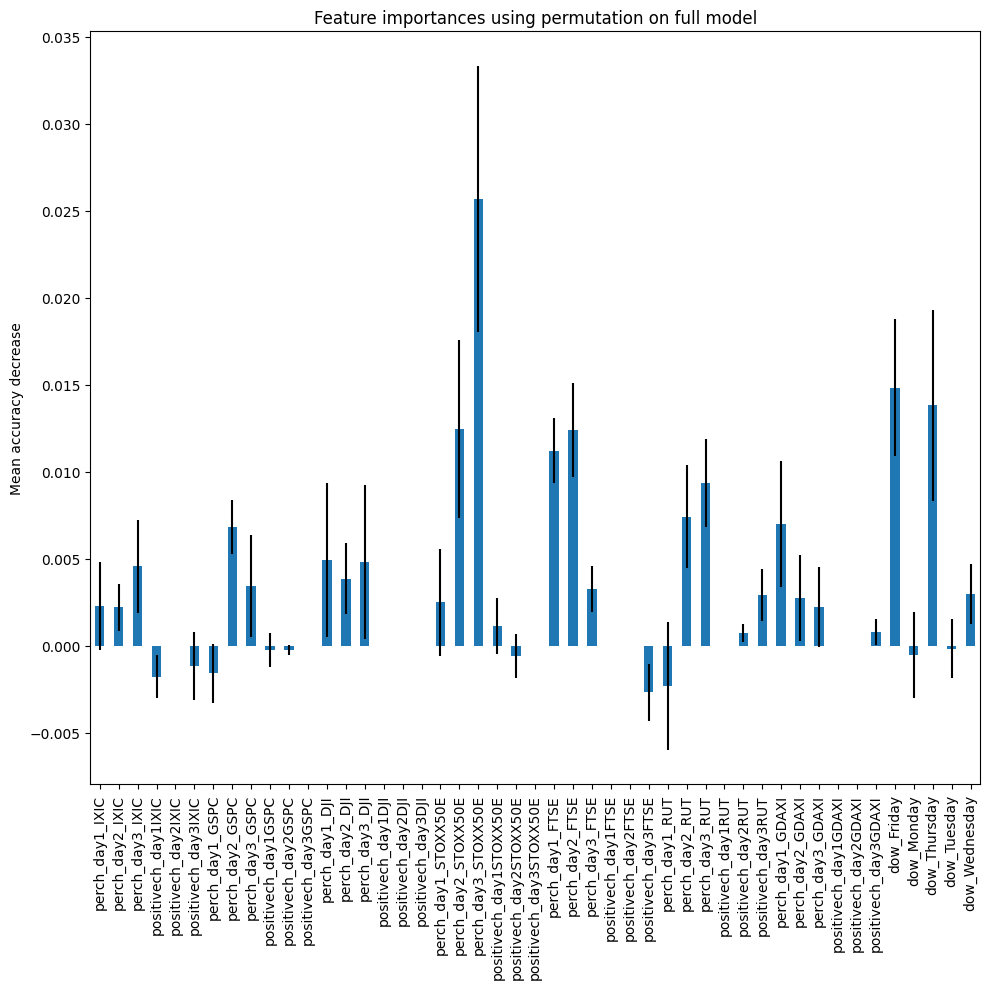

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

I will touch on this more in the analysis and conclusion, but it is interesting that the derived features of positive index change and day of the week were important in the model. 

### Boosting

In [45]:
forest_importances.sort_values(ascending=False)[:15].index

Index(['perch_day3_STOXX50E', 'dow_Friday', 'dow_Thursday',
       'perch_day2_STOXX50E', 'perch_day2_FTSE', 'perch_day1_FTSE',
       'perch_day3_RUT', 'perch_day2_RUT', 'perch_day1_GDAXI',
       'perch_day2_GSPC', 'perch_day1_DJI', 'perch_day3_DJI',
       'perch_day3_IXIC', 'perch_day2_DJI', 'perch_day3_GSPC'],
      dtype='object')

In [46]:
X_train_subset = X_train.loc[:,forest_importances.sort_values(ascending=False).index[:15]]
X_test_subset = X_test.loc[:,forest_importances.sort_values(ascending=False).index[:15]]

In [47]:
model_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(X_train_subset, y_train)

Boosting training precision score:  0.8932676518883416


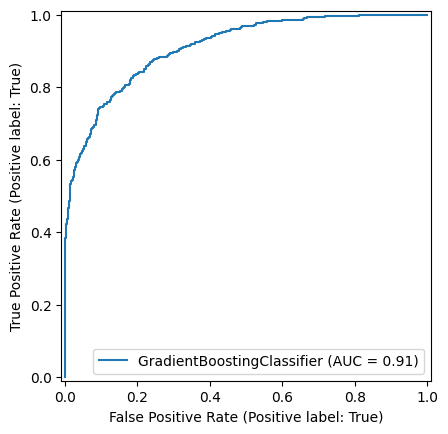

In [48]:
disp = RocCurveDisplay.from_estimator(model_boosting, X_train_subset, y_train)
boosting_precision_score = precision_score(y_train, model_boosting.predict(X_train_subset))
print("Boosting training precision score: ", boosting_precision_score)

## Results and Analysis

I considered that the day of the week might be important to the models, but I was still surprised to see the Monday and Friday one-hot encoded variables in the top features of importance in the Random Forest model. It is interesting that variables for index percent change for days other than 1 were relevant to the model. This suggests that more work could be done to see how trends over a few days, or interaction between variables could be used in the models.

### Final showdown
All of the training and analysis so far has been on training datasets. We will now see how the models compare using the test data.

Logistic Regression test precision score:  0.5441176470588235


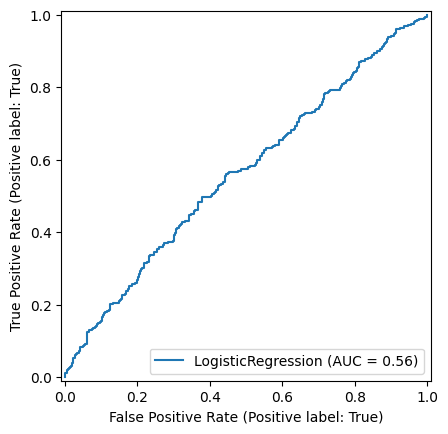

In [49]:
disp = RocCurveDisplay.from_estimator(LogReg, X_test, y_test)
log_precision_score = precision_score(y_test, LogReg.predict(X_test))
print("Logistic Regression test precision score: ", log_precision_score)

Random Forest test data precision score:  0.5381944444444444


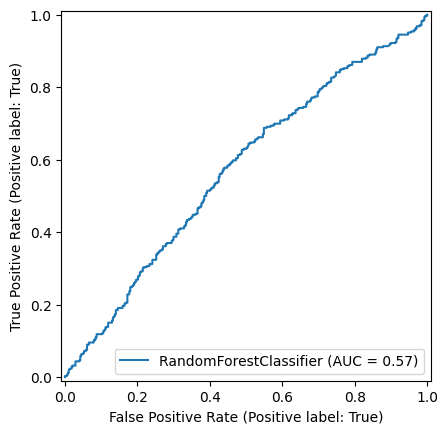

In [50]:
disp = RocCurveDisplay.from_estimator(model_rf, X_test, y_test)
y_pred = model_rf.predict(X_test)
rf_precision_score = precision_score(y_test, y_pred)
print("Random Forest test data precision score: ", rf_precision_score)

Boosting test precision score:  0.525691699604743


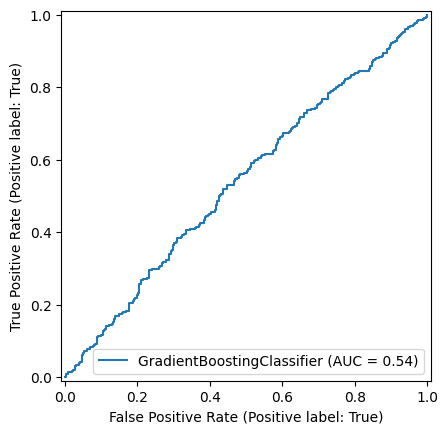

In [51]:
disp = RocCurveDisplay.from_estimator(model_boosting, X_test_subset, y_test)
boosting_precision_score = precision_score(y_test, model_boosting.predict(X_test_subset))
print("Boosting test precision score: ", boosting_precision_score)

What happened :) !!! Of course it would be too easy if a few variables could predict the outcome of a currency exchange pair. Clearly the models were overfit to the training data. This is exactly why we use a training - test split and adjust our models to the training data only.

We can try gradient boosting on the full set just to make sure....

In [52]:
model_boosting_fullset = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, validation_fraction=0.1,
    n_iter_no_change=10,random_state=42).fit(X_train, y_train)
# adding early stopping parameters to minimize overfitting https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html

Boosting training full set precision score:  0.9111617312072893


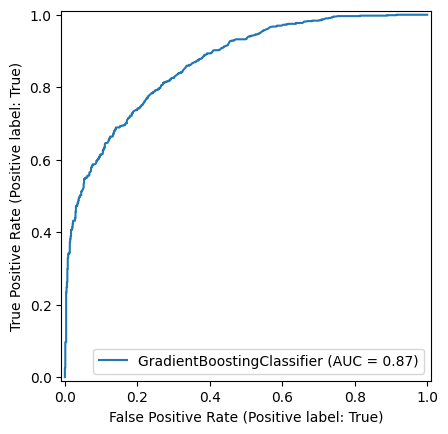

In [53]:
disp = RocCurveDisplay.from_estimator(model_boosting_fullset, X_train, y_train)
boosting_precision_score = precision_score(y_train, model_boosting_fullset.predict(X_train))
print("Boosting training full set precision score: ", boosting_precision_score)

Boosting test full set precision score:  0.5495049504950495


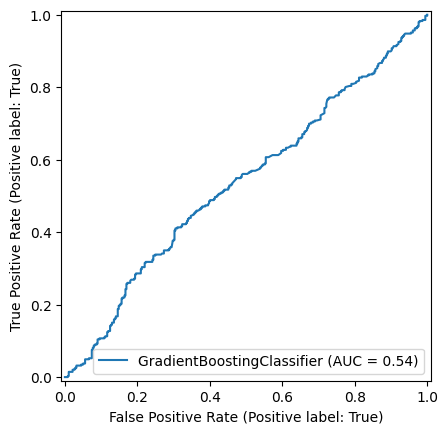

In [54]:
disp = RocCurveDisplay.from_estimator(model_boosting_fullset, X_test, y_test)
boosting_precision_score = precision_score(y_test, model_boosting_fullset.predict(X_test))
print("Boosting test full set precision score: ", boosting_precision_score)

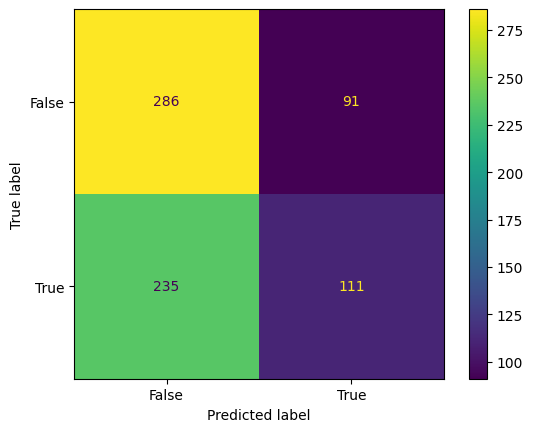

In [55]:
y_pred = model_boosting_fullset.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model_boosting_fullset.classes_).plot()

Logistic Regression training precision score:  0.5867875647668394
Random Forest training precision score:  0.6808943089430894
Boosting training precision score:  0.9001610305958132
Boosting training full set precision score:  0.9122137404580153

<b> Random Forest test data precision score:  0.49528301886792453 </b>

Overall the best model was the random forest model with a precision of 0.495 on the test set. It is interesting that the important features in training the model were if the day of the week was a Monday or Friday, and select index performance in the days prior. It is useful to see some features are more important than others even if the model does not perfectly predict the desired outcome. One of these, the DAX, surprised me because I added it just to see if it would help. https://www.investopedia.com/terms/d/dax.asp It is an index for companies in Germany, so it makes up part of the EUR trade. 
In theory the model <i> could </i> be used like this:
Given the recent stock index data at 5pm New York time, it is predicted that the EURUSD will drop 30 pips or more from the opening price (the time difference is 15 hours which is why the US stock markets close just before the Australia and Japan markets begin to open.) 

## Discussion and Conclusion
Predicting a forex pair activity with a few variables is a bit like predicting a coin flip. Still, the approach and data processing steps are sound. The overall hypothesis was that stock index movement in preceding days would signal strength for the US or EUR economies, and predict the movement of the currency pair in the next day's session. For example, if a US index closed up and a EUR index closed down, perhaps the next day the currency pair would go down significantly (> 30 pips) in response. 

I think the next steps would be to gather more indexes measures and create additional features that capture movement trends. Ideally the next models will also have key economic reporting dates so those can be accounted for.


